# Exploring Dandiset 001174: Calcium Imaging in SMA and M1 of Macaques

> **Note**: This notebook was generated with AI assistance. Users should carefully verify all code and results before use in research.

## Overview

This notebook introduces [Dandiset 001174](https://dandiarchive.org/dandiset/001174/0.250331.2218), which contains calcium imaging data recorded from the supplementary motor area (SMA) and primary motor cortex (M1) of rhesus macaques.

The dataset includes:
- One-photon calcium imaging videos using GCaMP6f
- Segmented cell traces and masks
- Data from 4 macaque subjects
- Recordings during rest and arm-reaching tasks

This notebook demonstrates how to:
1. Access NWB files using the DANDI API
2. Extract and visualize raw imaging frames
3. Work with ROI masks and fluorescence traces
4. Analyze cellular event patterns
5. Calculate basic population statistics

## Required Packages

```python
dandi
pynwb
h5py
remfile
numpy
matplotlib
pandas
```

## Accessing the Dandiset

First, we'll use the DANDI API to list available NWB files:

In [1]:
from dandi.dandiapi import DandiAPIClient
from itertools import islice

# Initialize DANDI client
client = DandiAPIClient()
dandiset = client.get_dandiset("001174", "0.250331.2218")

# List NWB files (first 20)
assets = list(islice(dandiset.get_assets_by_glob("*.nwb"), 20))

print(f"Number of .nwb files (showing up to 20): {len(assets)}\n")
for i, asset in enumerate(assets):
    print(f"{i+1}. {asset.path} - {asset.size/1e9:.2f} GB")

Number of .nwb files (showing up to 20): 20

1. sub-V/sub-V_ses-20230309T110929_ophys.nwb - 10.66 GB
2. sub-Q/sub-Q_ophys.nwb - 0.79 GB
3. sub-Q/sub-Q_ses-20220922T131747_ophys.nwb - 0.79 GB
4. sub-Q/sub-Q_ses-20221003T131952_ophys.nwb - 1.70 GB
5. sub-Q/sub-Q_ses-20221028T121142_ophys.nwb - 1.56 GB
6. sub-Q/sub-Q_ses-20221201T132256_ophys.nwb - 1.66 GB
7. sub-Q/sub-Q_ses-20221202T122907_ophys.nwb - 1.57 GB
8. sub-Q/sub-Q_ses-20221206T121002_ophys.nwb - 25.12 GB
9. sub-Q/sub-Q_ses-20220915T133954_ophys.nwb - 1.18 GB
10. sub-Q/sub-Q_ses-20221201T134628_ophys.nwb - 0.84 GB
11. sub-Q/sub-Q_ses-20221028T123313_ophys.nwb - 1.12 GB
12. sub-Q/sub-Q_ses-20220922T133032_ophys.nwb - 1.57 GB
13. sub-Q/sub-Q_ses-20221003T134805_ophys.nwb - 1.56 GB
14. sub-Q/sub-Q_ses-20221202T125146_ophys.nwb - 0.91 GB
15. sub-Q/sub-Q_ses-20221206T123719_ophys.nwb - 0.90 GB
16. sub-V/sub-V_ses-20230316T094035_ophys.nwb - 10.25 GB
17. sub-V/sub-V_ses-20230309T104556_ophys.nwb - 24.74 GB
18. sub-F/sub-F_ses-20240213

## Loading and Exploring an Example NWB File

Let's examine one file in detail. We'll use remote streaming to avoid downloading the full file:

In [2]:
import pynwb
import h5py
import remfile
import numpy as np
import matplotlib.pyplot as plt

# Select example file
asset_path = 'sub-Q/sub-Q_ses-20221206T121002_ophys.nwb'
asset = next(dandiset.get_assets_by_glob(asset_path))
url = asset.download_url

# Open file remotely
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

# Print basic metadata
print('Session description:', nwb.session_description)
print('Session start time:', nwb.session_start_time)
print('Subject ID:', nwb.subject.subject_id)
print('Species:', nwb.subject.species)
print('Sex:', nwb.subject.sex)
print('Age:', getattr(nwb.subject, 'age', 'n/a'))

Session description: Calcium imaging in SMA during the spontaneous condition
Session start time: 2022-12-06 12:10:02.429000+00:00
Subject ID: Q
Species: Macaca mulatta
Sex: F
Age: P5Y


## Visualizing Cell ROI Masks

The dataset contains spatial masks for each identified cell. Let's visualize their distribution:

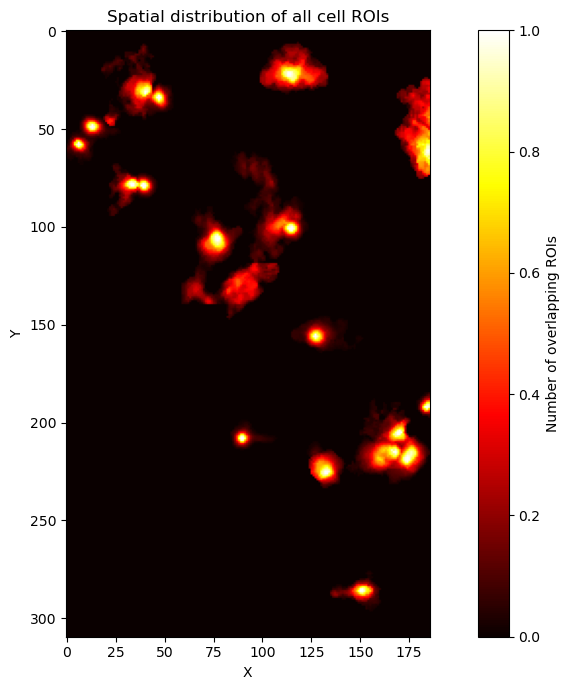


ROI Statistics:
Number of cells: 18
Mean ROI size: 447.8 ± 482.6 pixels


In [3]:
# Get cell masks from ImageSegmentation/PlaneSegmentation
ophys = nwb.processing['ophys']
plane_seg = ophys.data_interfaces['ImageSegmentation'].plane_segmentations['PlaneSegmentation']
roi_df = plane_seg.to_dataframe()

# Stack all binary masks into a maximum projection
mask_arrays = [plane_seg['image_mask'].data[i][:] for i in range(len(roi_df))]
mask_stack = np.stack(mask_arrays, axis=0)
max_mask = np.max(mask_stack, axis=0)

# Plot combined ROI map
plt.figure(figsize=(10,7))
plt.imshow(max_mask, cmap='hot')
plt.title('Spatial distribution of all cell ROIs')
plt.colorbar(label='Number of overlapping ROIs')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

# Calculate ROI sizes
roi_sizes = [np.count_nonzero(mask) for mask in mask_arrays]
print('\nROI Statistics:')
print(f'Number of cells: {len(roi_sizes)}')
print(f'Mean ROI size: {np.mean(roi_sizes):.1f} ± {np.std(roi_sizes):.1f} pixels')

## Examining Raw Imaging Data

Let's look at a brief segment of the raw calcium imaging movie:

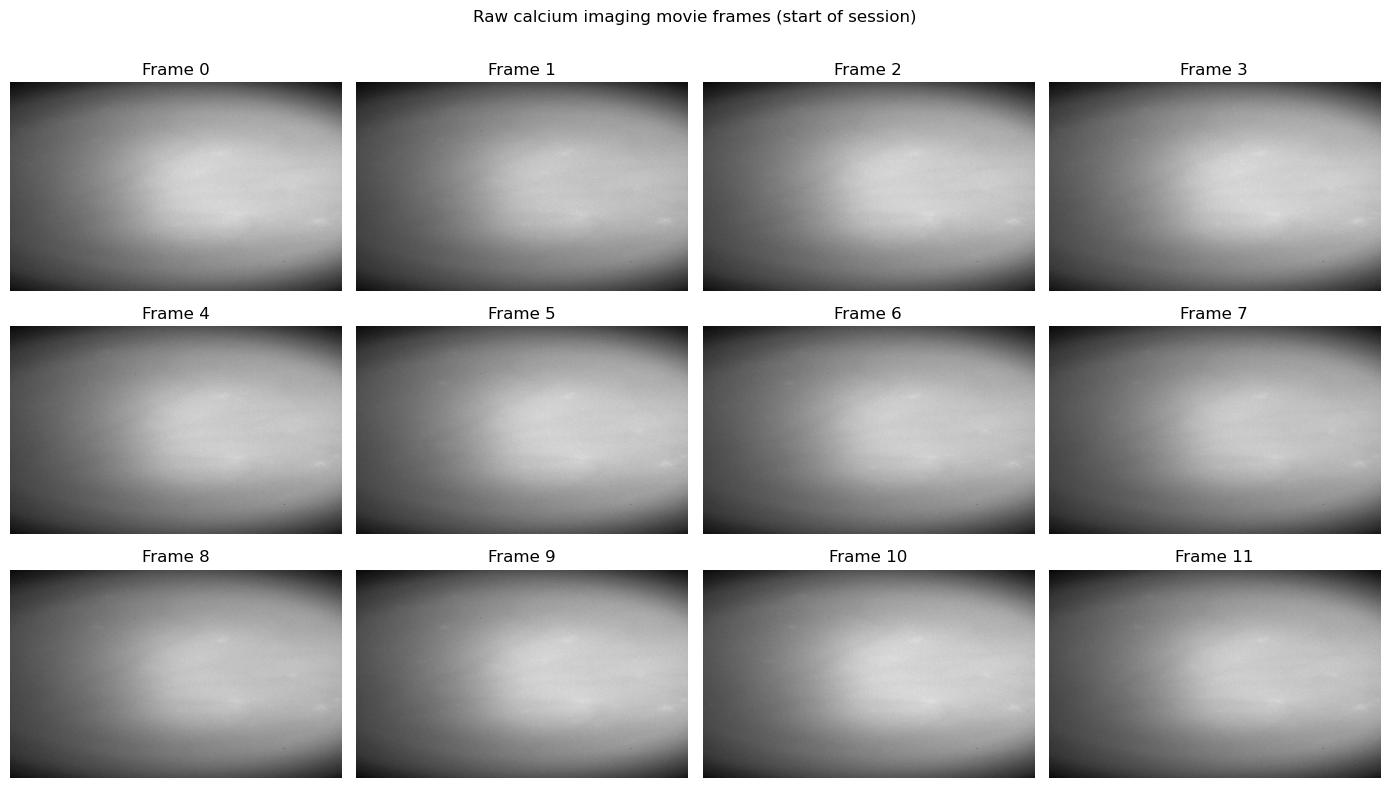

In [4]:
# Get raw movie frames
onphs = nwb.acquisition['OnePhotonSeries']
frames_to_show = 12  # ~1.2 seconds at 10 Hz
movie_segment = onphs.data[:frames_to_show]

# Create montage
n_cols = 4
n_rows = int(np.ceil(frames_to_show / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14,8))
for i in range(frames_to_show):
    ax = axes[i // n_cols, i % n_cols]
    ax.imshow(movie_segment[i], cmap='gray', aspect='auto')
    ax.set_title(f'Frame {i}')
    ax.axis('off')
for i in range(frames_to_show, n_rows*n_cols):
    axes.flat[i].axis('off')
plt.suptitle('Raw calcium imaging movie frames (start of session)')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## Analyzing Cellular Activity

Now let's examine the processed fluorescence traces and event detection:

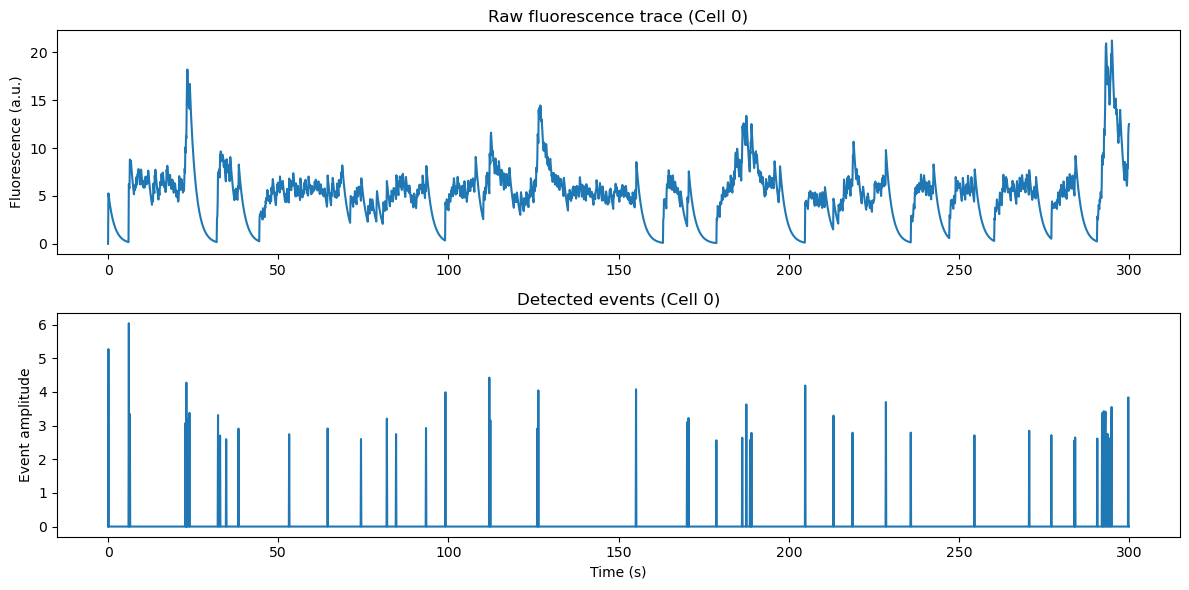


Population Statistics:
Mean event rate: 12.8 ± 19.5 events/min
Range: 0.6 to 71.0 events/min


In [5]:
# Get fluorescence and event data
rrs = ophys.data_interfaces['Fluorescence'].roi_response_series['RoiResponseSeries']
event_amp = ophys.data_interfaces['EventAmplitude']

# Calculate event rates
sampling_rate = rrs.rate
minutes = rrs.data.shape[0] / sampling_rate / 60
cell_event_counts = [(event_amp.data[:,i] > 0).sum() for i in range(len(roi_df))]
cell_event_rates = [count / minutes for count in cell_event_counts]

# Plot example cell trace and events
cell_idx = 0  # First cell
time = np.arange(3000) / sampling_rate  # First 5 minutes

plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(time, rrs.data[:3000, cell_idx])
plt.title(f'Raw fluorescence trace (Cell {cell_idx})')
plt.ylabel('Fluorescence (a.u.)')

plt.subplot(2,1,2)
plt.plot(time, event_amp.data[:3000, cell_idx])
plt.title(f'Detected events (Cell {cell_idx})')
plt.xlabel('Time (s)')
plt.ylabel('Event amplitude')
plt.tight_layout()
plt.show()

print('\nPopulation Statistics:')
print(f'Mean event rate: {np.mean(cell_event_rates):.1f} ± {np.std(cell_event_rates):.1f} events/min')
print(f'Range: {min(cell_event_rates):.1f} to {max(cell_event_rates):.1f} events/min')

## Suggested Next Steps

This dataset enables various analyses:
- Correlation between cell activity patterns
- Spatial organization of active cells
- Population dynamics during different behavioral states
- Comparison across subjects and brain regions
- Integration with behavioral task data

Interactive exploration is available via [NeuroSift](https://neurosift.app/nwb?dandisetId=001174&dandisetVersion=0.250331.2218&path=sub-Q/sub-Q_ses-20221206T121002_ophys.nwb).

## Cleanup

In [6]:
# Close open files
io.close()
h5_file.close()
remote_file.close()